# HSKA AI-Lab RL: Q-Learning

## Mount Google Drive as folder

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)
# %cd /content/drive/My\ Drive/ai-lab/rl

## Temporal-Difference Methoden

In diesem Notebook geht es darum Q-Learning anhand des Beispiels [CartPole](https://github.com/openai/gym/blob/master/gym/envs/classic_control/cartpole.py) zu implementieren. CartPole steht im OpenAI Gym zur Verfügung und wird in der Implementierung (`CartPoleEnv`) wie folgt beschrieben:

```python
"""
A pole is attached by an un-actuated joint to a cart, which moves along
a frictionless track. The pendulum starts upright, and the goal is to
prevent it from falling over by increasing and reducing the cart's
velocity.
"""
```

### CartPole Environment kennenlernen

In [1]:
%pip install -q --upgrade pip
%pip install -q pyglet==1.5.23
%pip install -q 'gym[atari]==0.21.0'
%pip install -q 'gym[classic_control]'
# %pip install gym

# !apt-get install -y xvfb python-opengl
%pip install -q PyOpenGL
%pip install -q pyvirtualdisplay

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import sys
import gym
import numpy as np
from operator import itemgetter

from pyvirtualdisplay import Display

import matplotlib.pyplot as plt
%matplotlib inline

from plot_utils import visualize_samples, plot_statistics
from abstract_agent import AbstractAgent

In [3]:
env = gym.make('CartPole-v1')

Ziel des Agenten ist es, den Pol so lange wie möglich aufrecht zu halten. Für jeden "Zeitschritt" den der Agent macht, bekommt dieser einen Reward von +1 (inkl. dem terminalen State). Die Episode terminiert, sobald der Polwinkel mehr als 15 Grad beträgt, die Wagenposition mehr als 2,4 (Mitte des Wagens erreicht den Rand der Anzeige) von der Mitte entfernt ist oder die Episodenlänge größer als 200 ist.

Gelöst gilt das CartPole-Problem, wenn folgendes gilt: der durchschnittliche Reward über 100 aufeinanderfolgende Versuche ist größer oder gleich 195,0 ist.

Der State setzt sich wie folgt zusammen:

```
Num	Observation               Min             Max
0	Cart Position             -4.8            4.8
1	Cart Velocity             -Inf            Inf
2	Pole Angle                -24 deg         24 deg
3	Pole Velocity At Tip      -Inf            Inf
```

Zu Beginn jeder Episode wird allen Beobachtungen ein einheitlicher Zufallswert in [-0.05..0.05] zugewiesen. Der State-Space (siehe `observation_space` in der nachfolgenden Zelle) ist fortlaufen (continuous state space).

Der Agent hat 2 mögliche Actions zur Auswahl, mit $\mathcal{A} =\{0, 1\}$ (siehe `action_space` in der nachfolgenden Zelle).:
```
PUSH CART TO THE LEFT = 0
PUSH CART TO THE RIGHT = 1
```

```
Note: The amount the velocity that is reduced or increased is not
fixed; it depends on the angle the pole is pointing. This is because
the center of gravity of the pole increases the amount of energy needed
to move the cart underneath it
```

In [4]:
# Explore the action space
print("Action space:", env.action_space)

# Generate some samples from the action space
print("Action space samples:")
print(np.array([env.action_space.sample() for i in range(10)]))

Action space: Discrete(2)
Action space samples:
[0 0 0 1 1 1 1 1 0 1]


Der State-Space und damit auch die Policy können hier, aufgrund der kontinuierlichen Werte die ein State annehmen kann, nicht mehr so einfach visuell dargestellt werden wie wir das bei dem `Tic-Tac-Toe` Environment gesehen haben.

In [5]:
# Explore state (observation) space
print("State space:", env.observation_space)
print("- low:", env.observation_space.low)
print("- high:", env.observation_space.high)

State space: Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)
- low: [-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38]
- high: [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38]


In [6]:
# Generate some samples from the state space 
print("State space samples:")
print(np.array([env.observation_space.sample() for i in range(10)]))

State space samples:
[[ 1.6060799e+00  1.8363714e+38 -2.6602653e-01  2.7629603e+38]
 [-1.9115361e+00  1.6877922e+38 -1.6628022e-01  1.4958410e+38]
 [ 4.1589236e+00  3.0463354e+38  2.5136396e-01  2.6816446e+37]
 [-2.3418846e+00  9.6763533e+37  2.3289371e-01  2.7685745e+38]
 [ 2.4918411e+00  1.7251684e+38  3.3421332e-01 -6.0018048e+37]
 [-4.0869665e+00  1.9191167e+38 -5.4946743e-02  2.7044167e+38]
 [ 4.7909851e+00 -2.1316944e+38 -8.1670024e-02  1.7494288e+38]
 [ 8.4277666e-01  4.6534003e+37  2.9460534e-01  2.0578385e+36]
 [ 1.6020851e+00 -5.9100594e+37 -3.8224441e-01  2.9068078e+38]
 [-1.7621667e+00 -3.2823015e+38 -4.8267923e-02  7.8412135e+37]]


Nachfolgend wird ein Agent gezeigt, der zufällig über dem Action-Space sampled und die entsprechenden Actions ausführt. Den Score gilt es dann im Laufe des Notebooks zu verbessern und schließlich das Environment zu lösen.

Score:  10


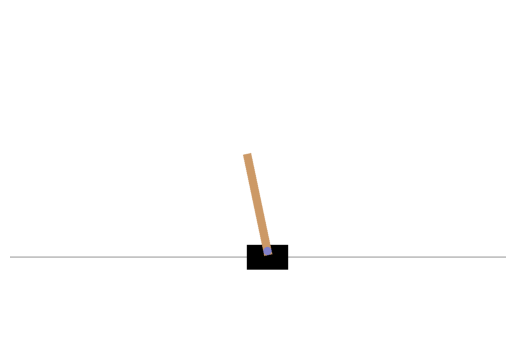

In [7]:
# Random agent

# Set plotting options
plt.style.use('ggplot')
np.set_printoptions(precision=3, linewidth=120)

display = Display(visible=0, size=(1400, 900))
display.start()

is_ipython = 'inline' in plt.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

env.seed(505);

state = env.reset()
img = plt.imshow(env.render(mode='rgb_array'))
for t in range(1000):
    action = env.action_space.sample()
    img.set_data(env.render(mode='rgb_array')) 
    plt.axis('off')
    display.display(plt.gcf())
    display.clear_output(wait=True)
    state, reward, done, _ = env.step(action)
    if done:
        print('Score: ', t+1)
        break
        
env.close()

### Aufgabe 2.1: Diskretisierung des State-Spaces

Im vorherigen Abschnitt haben wir gesehen, dass der State-Space kontinuierlich ist und wir damit zu viele Zustände haben, um diese in einer einfachen Q-Tabelle zu speichern. Eine Möglichkeit, dieses Problem in den Griff zu bekommen, ist die Diskretisierung des State-Spaces, um die Q-Werte wieder tabellarisch ablegen zu können.

Für das bessere Verständnis dafür, wie das hinterher aussehen soll, wird nachfolgend die Diskretisierung des State-Spaces anhand der Features `Cart Position` und `Cart Velocity` exemplarisch gezeigt.

/Users/sschwarzer/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3457: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


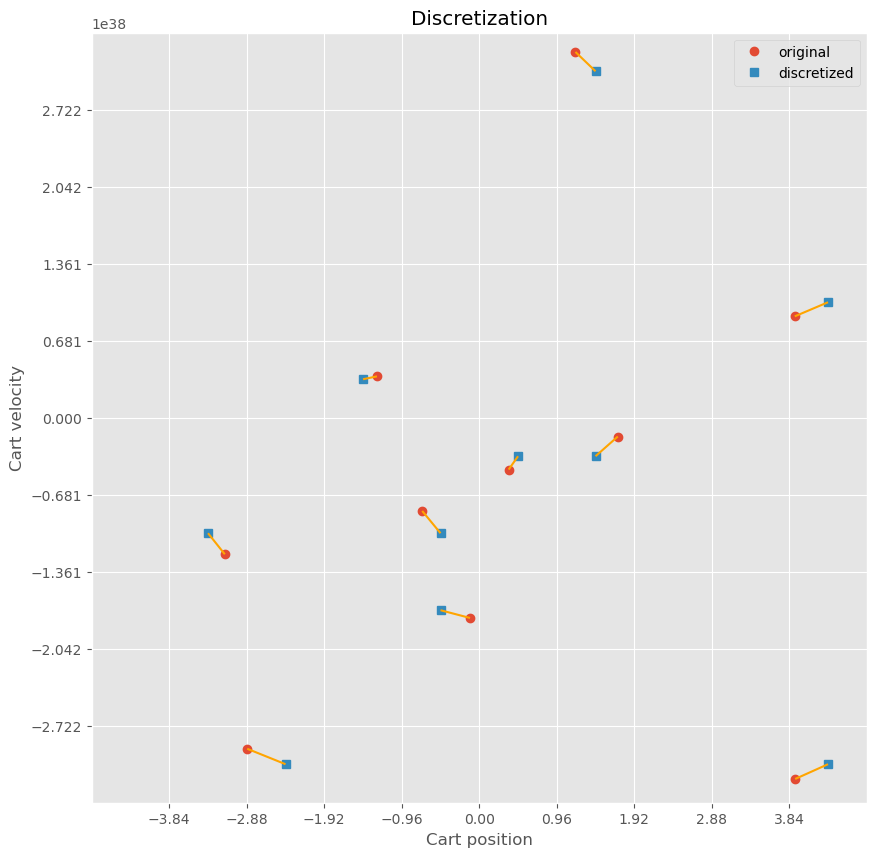

In [8]:
# Example data for visualization of disrectized cart features
samples = np.array([[-2.875e+00, -2.926e+38],
                    [-1.143e-01, -1.770e+38],
                    [ 3.638e-01, -4.583e+37],
                    [ 3.908e+00,  8.961e+37],
                    [ 3.913e+00, -3.193e+38],
                    [-7.072e-01, -8.241e+37],
                    [ 1.191e+00,  3.233e+38],
                    [-3.152e+00, -1.207e+38],
                    [-1.267e+00,  3.655e+37],
                    [ 1.716e+00, -1.660e+37]])
discretized_samples = np.array([[2, 0],
                                [4, 2],
                                [5, 4],
                                [9, 6],
                                [9, 0],
                                [4, 3],
                                [6, 9],
                                [1, 3],
                                [3, 5],
                                [6, 4]])
grid = [np.array([-3.84, -2.88, -1.92, -0.96,  0.  ,  0.96,  1.92,  2.88,  3.84]),
        np.array([-2.722e+38, -2.042e+38, -1.361e+38, -6.806e+37,  0.000e+00,  6.806e+37,  1.361e+38,  2.042e+38,  2.722e+38])]
low = [-4.800e+00, -3.403e+38]
high = [4.800e+00, 3.403e+38]

visualize_samples(samples, discretized_samples, grid, low, high,
                  x_label='Cart position', y_label='Cart velocity')

Wir werden den State-Space durch ein gleichmäßiges Raster diskretisieren. Implementiert die folgende Methode, um ein solches Gitter unter Berücksichtigung der unteren Grenzen (`low`), der oberen Grenzen (`high`) und der Anzahl der gewünschten `bins` entlang jeder Dimension zu erstellen. Die Methode sollte die Aufteilungspunkte für jede Dimension zurückgeben. Die Anzahl der Aufteilungspunkte ist um 1 kleiner als die Anzahl der Bins.

Zum Beispiel, wenn `low = [-1.0, -5.0]`, `high = [1.0, 3.0]` und `bins = (10, 10)`, dann sollte die Methode folgende `list` von zwei NumPy Arrays zurückgeben:

```
[array([-0.8, -0.6, -0.4, -0.2,  0.0,  0.2,  0.4,  0.6,  0.8]),
 array([-4.0, -3.0, -2.0, -1.0,  0.0,  1.0,  2.0,  3.0,  4.0])]
```

Dieses erzeuget Grid wird dann verwendet, um die kontinuierlichen Werte des Environments konkreten Zellen in dem Grid zuzuweisen und damit den State-Space zu vereinfachen.

**Wichtig**: Die Randwerte von `low` und `high` sind **nicht** in den Aufteilungspunkten enthalten. Es wird angenommen, dass jeder Wert unterhalb des niedrigsten Aufteilungspunktes dem Index `0` und jeder Wert oberhalb des höchsten Aufteilungspunktes dem Index `n-1` zugeordnet wird, wobei `n` die Anzahl der Behälter entlang dieser Dimension ist.

> Beschreibung oben ist falsch. high muss [1, 5] sein

In [21]:
def create_uniform_grid(low, high, bins=(10, 10)):
    """Create a uniformly-spaced grid that can be used to discretize a space.
    
    Args:
        low [array]: Lower bounds for each dimension of the continuous space.
        high [array]: Upper bounds for each dimension of the continuous space.
        bins [tuple]: Number of bins along each corresponding dimension.
    
    Returns:
        grid [list]: List of arrays containing split points for each dimension.
    """
    assert len(low) == len(high), 'Dimensions of low and high should be equal'
    # TODO
    return [np.linspace(lower, upper, nums, False)[1:] for lower, upper, nums in zip(low, high, bins)]

# Test implementation
low = [-1.0, -5.0]
high = [1.0, 5.0]
create_uniform_grid(low, high)

[array([-0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8]),
 array([-4., -3., -2., -1.,  0.,  1.,  2.,  3.,  4.])]

In [22]:
# Assertions, please do not change
assert len(create_uniform_grid([0, 0, 0], [1, 1, 1], (1, 1, 1))) == 3, 'Grid shape not matching input values. Please check implementation'
assert np.allclose(create_uniform_grid([-42., -3.14], [0.1, 0.11], (3, 5))[1], np.array([-2.49, -1.84, -1.19, -0.54])), 'Grid is not as expected. Please check implementation'

In [54]:
x = [[-1.0 , -5.0],
[-0.81, -4.1],
[-0.8 , -4.0],
[-0.5 ,  0.0],
[ 0.2 , -1.9],
[ 0.8 ,  4.0],
[ 0.81,  4.1],
[ 1.0 ,  5.0]]
bins = create_uniform_grid(low, high)


[array([0, 0, 1, 2, 5, 9, 9, 9]), array([0, 0, 1, 5, 3, 9, 9, 9])]

Schreibt nun eine Methode, die Samples aus einem kontinuierlichen State-Space in seine äquivalente diskretisierte Darstellung umwandeln kann, wobei ein Grid wie das oben erstellte vorgegeben wird. Zu diesem Zweck kannst Du die Methode `numpy.digitize()` verwenden.

Angenommen, das Grid ist eine Liste von NumPy-Arrays mit den folgenden Aufteilungspunkten:
```
[array([-0.8, -0.6, -0.4, -0.2,  0.0,  0.2,  0.4,  0.6,  0.8]),
 array([-4.0, -3.0, -2.0, -1.0,  0.0,  1.0,  2.0,  3.0,  4.0])]
```

Hier sind einige potenzielle Beispiele und ihre entsprechenden diskretisierten Darstellungen:
```
[-1.0 , -5.0] => [0, 0]
[-0.81, -4.1] => [0, 0]
[-0.8 , -4.0] => [1, 1]
[-0.5 ,  0.0] => [2, 5]
[ 0.2 , -1.9] => [6, 3]
[ 0.8 ,  4.0] => [9, 9]
[ 0.81,  4.1] => [9, 9]
[ 1.0 ,  5.0] => [9, 9]
```

**Wichtig**: Es kann einmalige Unterschiede beim Binning aufgrund von Fließkomma-Ungenauigkeiten geben, wenn die Samples nahe an den Grid-Grenzen liegen, aber das ist in Ordnung.

In [65]:
def discretize(sample, grid):
    """Discretize a sample as per given grid.
    
    Args:
        sample [array]: Single sample from the (original) continuous space.
        grid [list]: List of arrays containing split points for each dimension.
    
    Returns:
        discretized_sample [array]: Sequence of integers with the same number of dimensions as sample.
    """
    # TODO
    return [np.digitize(x, bins) for x, bins in zip(sample, grid)]

# Test implementation
grid = create_uniform_grid([-1.0, -5.0], [1.0, 5.0])
samples = np.array(
    [[-1.0 , -5.0],
     [-0.81, -4.1],
     [-0.8 , -4.0],
     [-0.5 ,  0.0],
     [ 0.2 , -1.9],
     [ 0.8 ,  4.0],
     [ 0.81,  4.1],
     [ 1.0 ,  5.0]])
discretized_samples = np.array([discretize(sample, grid) for sample in samples])
print("\nSamples:", repr(samples), sep="\n")
print("\nDiscretized samples:", repr(discretized_samples), sep="\n")


Samples:
array([[-1.  , -5.  ],
       [-0.81, -4.1 ],
       [-0.8 , -4.  ],
       [-0.5 ,  0.  ],
       [ 0.2 , -1.9 ],
       [ 0.8 ,  4.  ],
       [ 0.81,  4.1 ],
       [ 1.  ,  5.  ]])

Discretized samples:
array([[0, 0],
       [0, 0],
       [1, 1],
       [2, 5],
       [5, 3],
       [9, 9],
       [9, 9],
       [9, 9]])


In [66]:
# Assertions, please do not change
samples = np.array([[-24.2, -3.1], [-0.5401, -0.5399]])
grid = create_uniform_grid([-42., -3.14], [0.1, 0.11], (3, 5))

assert len(discretize(np.array([[-24.2, -3.1], [0.1011, 0.10009]]), create_uniform_grid([-42., -3.14], [0.1, 0.11], (3, 5)))) == 2, 'Output shape not matching input shape. Please check implementation'
assert np.allclose([discretize(sample, grid) for sample in samples][0], np.array([1, 0])), 'Discretized samples are not as expected. Please check implementation'
assert np.allclose([discretize(sample, grid) for sample in samples][1], np.array([2, 4])), 'Discretized samples are not as expected. Please check implementation'

#### Diskretisierte Features: 'Cart Position' und 'Cart Velocity'

Nachfolgend werden, wie eingangs exemplarisch gezeigt, die diskretisierten Features des `CartPole` Environment anhand von zufällig gesampleten Stichproben visualisiert.

**Wichtig**: Bei den Ober- und Untergrenzen für das Grid ist Vorsicht geboten, wenn man direkt die Environment Grenzen einsetzt (`env.observation_space.low` und `env.observation_space.high`), da diese zu `inf` bzw `-inf` Werten im Grid führen.

State grid:  [array([-3.84, -2.88, -1.92, -0.96,  0.  ,  0.96,  1.92,  2.88,  3.84]), array([-2.722e+38, -2.042e+38, -1.361e+38, -6.806e+37,  0.000e+00,  6.806e+37,  1.361e+38,  2.042e+38,  2.722e+38])]


/Users/sschwarzer/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3457: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


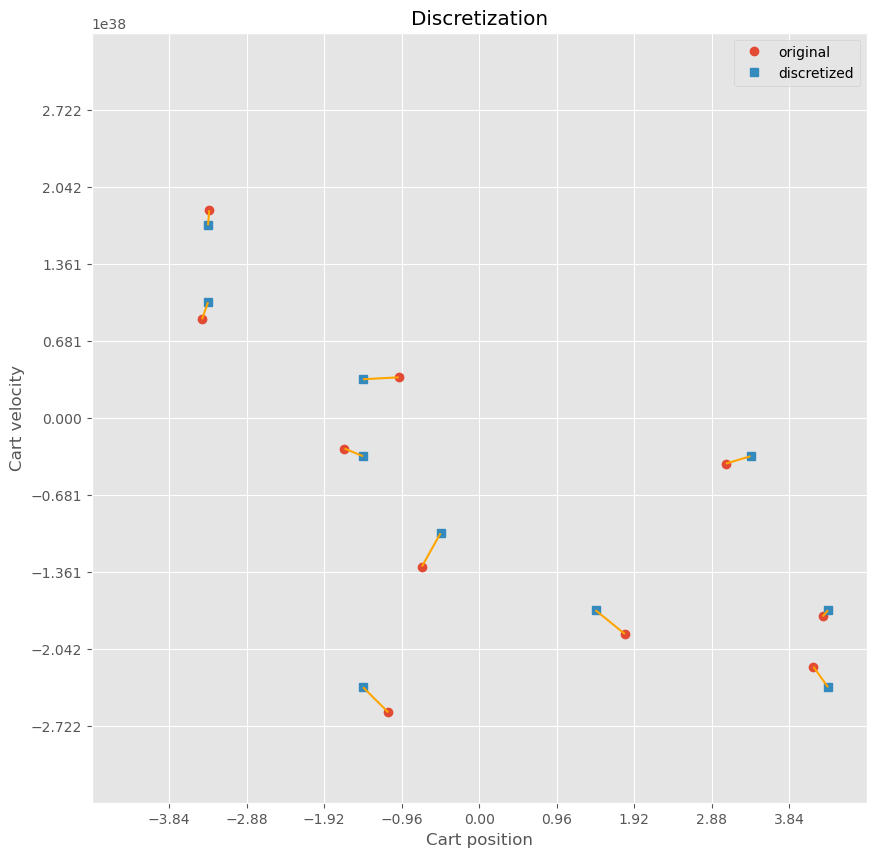

In [67]:
low = [-4.800e+00, -3.403e+38, -4.189e-01, -3.403e+38]
high = [4.800e+00, 3.403e+38, 4.189e-01, 3.403e+38]

state_grid = create_uniform_grid(low[:2], high[:2], bins=(10, 10))
print('State grid: ', state_grid)

# Get samples from the state space, discretize and visualize them
state_samples = np.array([env.observation_space.sample()[:2] for i in range(10)])
discretized_state_samples = np.array([discretize(sample, state_grid) for sample in state_samples])

visualize_samples(state_samples, discretized_state_samples, state_grid, low[:2], high[:2],
                  x_label='Cart position', y_label='Cart velocity')

#### Diskretisierte Features: 'Pole Angle' und 'Pole Velocity At Tip'

State grid:  [array([-3.351e-01, -2.513e-01, -1.676e-01, -8.378e-02, -5.551e-17,  8.378e-02,  1.676e-01,  2.513e-01,  3.351e-01]), array([-2.722e+38, -2.042e+38, -1.361e+38, -6.806e+37,  0.000e+00,  6.806e+37,  1.361e+38,  2.042e+38,  2.722e+38])]


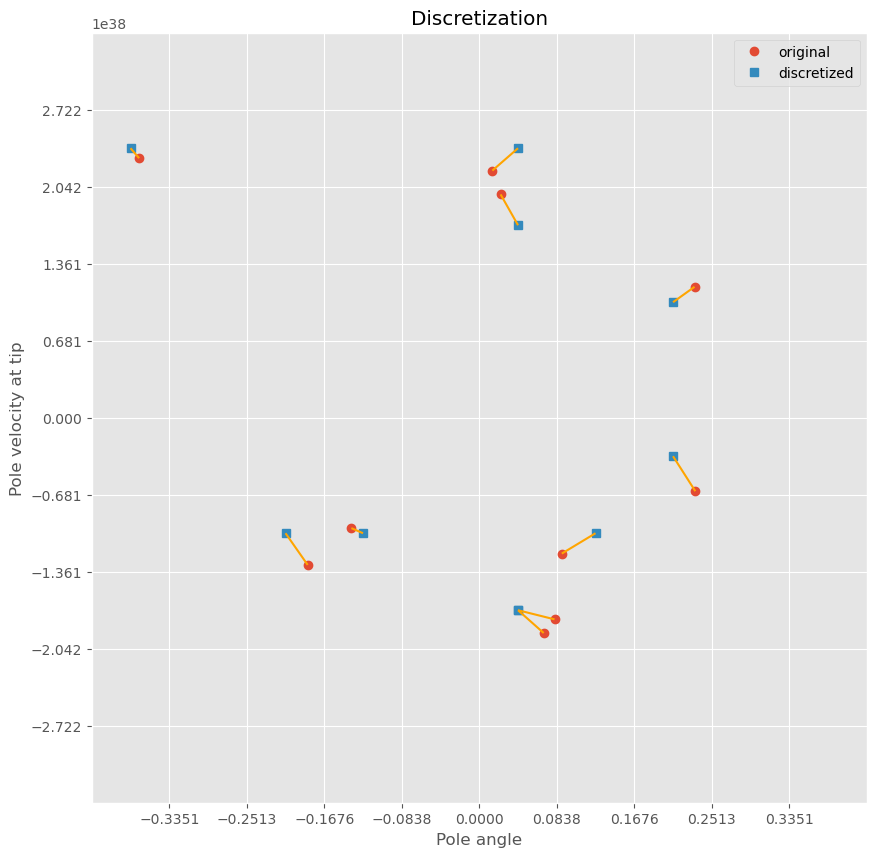

In [68]:
state_grid = create_uniform_grid(low[2:], high[2:], bins=(10, 10))
print('State grid: ', state_grid)

# Get samples from the state space, discretize and visualize them
state_samples = np.array([env.observation_space.sample()[2:] for i in range(10)])
discretized_state_samples = np.array([discretize(sample, state_grid) for sample in state_samples])

visualize_samples(state_samples, discretized_state_samples, state_grid, low[2:], high[2:],
                 x_label='Pole angle', y_label='Pole velocity at tip')

### Aufgabe 2.2: Q-Learning mit CartPole

Mit Hilfe des vereinfachten State-Spaces soll nun, das `CartPole` Environment mittels Q-Learning gelöst werden. Dazu müssen hier dazu wieder die Methoden `act` und `train` implementiert werden. Dazu kommt, dass der Agent dieses Mal vom `AbstractAgent` erbt und die Klasse entsprechend initialisiert werden muss (siehe `# TODO` im Code). Zusätzlich sollten die Hyperparameter (`epsilon` und `alpha`) aktualisiert werden (Stichwort 'epsilon-/alpha-decay'), nachdem eine Episode abgeschlossen wurde (`done` ist `True`). Der Main-Loop ist dieses Mal gegeben. Dort wird die oben implementierte Diskretisierung angewendet:

- `__init__`: Konstruktor der agent Klassen
- `act`: Implementiert $\epsilon$-greedy Exploration-Strategy
- `train`: Lernen der Q-Funktion anhand der gesammelten Erfahrungen

**Wichtig**: Um das entsprechende `PASSED` für das CartPole Environment zu bekommen, muss, wie oben beschrieben, ein durchschnittlicher Reward >= 195,0 über 100 aufeinanderfolgende Episoden erreicht werden. Es ist empfehlenswert, nach der Implementierung des Agenten, sich die Hyperparameter genauer anzuschauen, um die optimalen Parameter für die Initialisierung des Agenten zu finden.

In [ ]:
class QLearningAgent(AbstractAgent):

    def __init__(self, state_grid, action_size, gamma=None, epsilon=None, epsilon_min=None,
                 alpha=None, alpha_min=None):
        self.state_grid = state_grid
        self.state_size = tuple(len(splits) + 1 for splits in self.state_grid)
        self.action_size = action_size
        
        print("State space size:", self.state_size)
        print("Action space size:", self.action_size)

        # Hyperparameter
        self.gamma = gamma # discount factor (how much discount future reward)
        self.epsilon = epsilon # exploration rate for the agent
        self.alpha = alpha # learning rate
        self.epsilon_min = epsilon_min
        self.alpha_min = alpha_min

        # Initialize Q[s,a] table
        self.Q = np.array([]) # TODO
        print("Q table size:", self.Q.shape)
        
        self.t = 0 # played episodes

    def act(self, state):
        """Selects the action to be executed based on the given state.
        
        Implements epsilon greedy exploration strategy, i.e. with a probability of
        epsilon, a random action is selected.
        
        Args:
            state [tuple]: Tuple of agent and target position, representing the state.
        
        Returns:
            action [int]
        """
        # TODO
        # https://www.geeksforgeeks.org/epsilon-greedy-algorithm-in-reinforcement-learning/
        if self.epsilon == None:
            return 0
        
        return (
            np.random.choice(self.action_size)
            if np.random.random() <= self.epsilon
            else self.Q
        )

    def train(self, experience):
        """Learns the Q-values based on experience.
        
        Args:
            experience [tuple]: Tuple of state, action, next state, reward, done.
        
        Returns:
            None
        """
        # TODO

        if done:
            # Update hyperparameter
            # TODO
            self.t += 1

In [ ]:
# Assertions, please do not change
test_agent = QLearningAgent([np.array([2,3]),np.array([1,2,3])], 3, gamma=5, epsilon=0.8, alpha=2)
assert test_agent.Q.shape == (3, 4, 3), 'Q-table in agent should be initialized correctly. Please check init method'
np.random.seed(42)
test_agent.action_size = 3; test_agent.epsilon = 1.0; test_agent.Q = np.array([[[[[.5, 0.],[0., 0.]],[[0., 0.],[0., 0.]]],[[[0., 0.],[0., 0.]],[[0., 0.],[0.,0.]]]],[[[[0., 0.],[0., 0.]],[[0., 0.],[0., 0.]]],[[[0., 0.],[0., 0.]],[[0., 0.],[.1, .2]]]]])
assert test_agent.act((1,2,3,1)) == 0, 'Agent should explore the environment. Please check agent act method'
test_agent.epsilon = 0.0
assert test_agent.act((1,1,1,1)) == 1, 'Agent should exploit the environment. Please check agent act method'
test_agent.train(((1,1,1,1),1,(0,0,0,0),5,False))
assert np.allclose(test_agent.Q, np.array([[[[[.5, 0.],[0., 0.]],[[0., 0.],[0., 0.]]],[[[0., 0.],[0., 0.]],[[0., 0.],[0.,0.]]]],[[[[0., 0.],[0., 0.]],[[0., 0.],[0., 0.]]],[[[0., 0.],[0., 0.]],[[0., 0.],[.1, 14.8]]]]])), 'Q update incorrect. Please check agent train method'

In [ ]:
from contextlib import suppress

def interact_with_environment(env, agent, n_episodes=1000, max_steps=200, train=True, verbose=False):      
    statistics = []
    
    with suppress(KeyboardInterrupt):
        for episode in range(n_episodes):
            done = False
            total_reward = 0
            state = env.reset()
            state = tuple(discretize(state, agent.state_grid)) # transform state

            if verbose and episode == n_episodes-1:
                img = plt.imshow(env.render(mode='rgb_array'))
            
            for t in range(max_steps):
                action = agent.act(state)
                
                if verbose and episode == n_episodes-1:
                    img.set_data(env.render(mode='rgb_array'))
                    plt.axis('off')
                    display.display(plt.gcf())
                    display.clear_output(wait=True)
                
                next_state, reward, done, _ = env.step(action)
                next_state = tuple(discretize(next_state, agent.state_grid))

                if train:
                    agent.train((state, action, next_state, reward, done))

                state = next_state
                total_reward += reward

                if done:
                    break

            if verbose and episode % 10 == 0:
                print("\rEpisode: {}/{} | Score: {}".format(episode, n_episodes, total_reward), end="")
                sys.stdout.flush()

            statistics.append({
                'episode': episode,
                'score': total_reward,
                'steps': t
            })
        
    return statistics

In [ ]:
# Hyperparams
# TODO: Find better values
gamma = 0.75
epsilon = 0.75
epsilon_min = 0.1
alpha = 0.75
alpha_min = 0.1
bins = (10, 10, 10, 10)

# State grid
low = [-4.800e+00, -3.403e+38, -4.189e-01, -3.403e+38]
high = [4.800e+00, 3.403e+38, 4.189e-01, 3.403e+38]
state_grid = create_uniform_grid(low, high, bins=bins)

agent = QLearningAgent(state_grid=state_grid, action_size=env.action_space.n, gamma=gamma, 
                       epsilon=epsilon, epsilon_min=epsilon_min, alpha=alpha, alpha_min=alpha_min)

statistics = interact_with_environment(env, agent, n_episodes=1000, verbose=True)
plot_statistics(statistics)

assert len(statistics) >= 100, 'Please run at least 100 episodes for validating result'
print('Mean over last 100 episodes: {}'.format(np.mean(list(map(itemgetter('score'), statistics[-100:])))))

### Quiz: Q-Learning

#### Frage: Was könnte man bei der Diskretisierung optimieren?

Antwort: # TODO